# Jago:

## Import packages:

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk 
import gensim
import re
import datetime
import collections
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Load dataset:

In [2]:
trains24 = pd.read_csv("./Dataset/articoliS24O.csv", delimiter="\t")
trainRadiocor = pd.read_csv("./Dataset/articoliRadiocor.csv", delimiter='\t')

In [3]:
colsel_trains24 = trains24[['identificativo', 'body']]
colsel_trains24.head()

,identificativo,body
0,FM20160429032ACC9MUHD,Acea è pronta a giocare la sua partita sulla b...
1,FM20160501023ACLAzwID,"L’unica certezza, per il momento, è che la pro..."
2,FM20160503035ACaNSzJD,Si potrebbe aspettare il mese di luglio per la...
3,FM20160503035ACDx00JD,Un fondo chiuso per aiutare le piccole e medie...
4,FM20160428033ACi2kvGD,A volte le provocazioni sortiscono l’effetto s...


In [4]:
colsel_trainRadiocor = trainRadiocor[['identificativo', 'body']]
colsel_trainRadiocor.head()

,identificativo,body
0,RR201611141524426,L'obiettivo e' raccolta fondi per supporto a f...
1,RR201611141638439,L'obiettivo e' raccolta fondi per supporto a f...
2,RR201611141655450,"(Il Sole 24 Ore Radiocor Plus) - Milano, 14 no..."
3,RR201611101529490,"(Il Sole 24 Ore Radiocor Plus) - Milano, 10 no..."
4,RR201611101517481,"(Il Sole 24 Ore Radiocor Plus) - Milano, 10 no..."


In [5]:
colsel_merged = pd.concat([colsel_trains24, colsel_trainRadiocor])
colsel_merged.shape

(10181, 2)

In [6]:
colsel_merged.dropna(inplace=True)
colsel_merged = colsel_merged.reset_index()
colsel_merged = colsel_merged.drop('index', axis=1)

In [7]:
colsel_merged.head()

,identificativo,body
0,FM20160429032ACC9MUHD,Acea è pronta a giocare la sua partita sulla b...
1,FM20160501023ACLAzwID,"L’unica certezza, per il momento, è che la pro..."
2,FM20160503035ACaNSzJD,Si potrebbe aspettare il mese di luglio per la...
3,FM20160503035ACDx00JD,Un fondo chiuso per aiutare le piccole e medie...
4,FM20160428033ACi2kvGD,A volte le provocazioni sortiscono l’effetto s...


## Clean dataset:

In [8]:
colsel_merged['body'] = colsel_merged['body'].apply(lambda x : str(x).lower())
colsel_merged['body'] = colsel_merged['body'].str.replace(r'( )+',' ')
colsel_merged['body'] = colsel_merged['body'].str.replace('\n','')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'il( )?sole( )?24( )?ore','sole24ore')
colsel_merged['body'] = colsel_merged['body'].str.replace('(milion(i|e)|miliard(i|o)|euro)','')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'((\()?( )?sole24ore (radiocor)?( plus)?( )?(\))?.\-.*?)\-','')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'(continua (da )?pagina [0-9]+)© riproduzione riservata(continua (da )?pagina [0-9]+)', '')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'((© )?riproduzione riser(vata)?).*','') 
colsel_merged['body'] = colsel_merged['body'].str.replace(r'(www\.|http\:\/\/|https\:\/\/|\.com|\.net|\.org|\.it|@[a-zA-Z]+)','')
colsel_merged['body'] = colsel_merged['body'].str.replace(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?','')  
print("SHAPE BEFORE REMOVING DUPLICATES: " + str(colsel_merged.shape)) 
colsel_merged.drop_duplicates(inplace=True) 
print("SHAPE AFTER REMOVING DUPLICATES: " + str(colsel_merged.shape)) 
colsel_merged['body'] = colsel_merged['body'].apply(lambda x: BeautifulSoup(str(x), "lxml").get_text())

SHAPE BEFORE REMOVING DUPLICATES: (10150, 2)
SHAPE AFTER REMOVING DUPLICATES: (9283, 2)


In [9]:
def tagDocuments(text):
    for i, line in enumerate(text):
        if(i%1000 == 0):
            print("> Iteration: " + str(i))
        yield gensim.models.doc2vec.TaggedDocument([w for w in gensim.utils.simple_preprocess(line) if not w in stopwords.words("italian")], [i])

In [10]:
colsel_merged = colsel_merged.reset_index()
colsel_merged = colsel_merged.drop('index', axis=1)
colsel_merged.head()

,identificativo,body
0,FM20160429032ACC9MUHD,acea è pronta a giocare la sua partita sulla b...
1,FM20160501023ACLAzwID,"l’unica certezza, per il momento, è che la pro..."
2,FM20160503035ACaNSzJD,si potrebbe aspettare il mese di luglio per la...
3,FM20160503035ACDx00JD,un fondo chiuso per aiutare le piccole e medie...
4,FM20160428033ACi2kvGD,a volte le provocazioni sortiscono l’effetto s...


## Extract train data from dataframe into list:

In [11]:
print("> START %s" % datetime.datetime.now())
train_corpus = list(tagDocuments(colsel_merged['body'].tolist()))
print("> END %s" % str(datetime.datetime.now()))

len(train_corpus)

> START 2017-03-17 18:54:10.117164
> Iteration: 0
> Iteration: 1000
> Iteration: 2000
> Iteration: 3000
> Iteration: 4000
> Iteration: 5000
> Iteration: 6000
> Iteration: 7000
> Iteration: 8000
> Iteration: 9000
> END 2017-03-17 19:00:33.957372


9283

## Prepare model:

In [12]:
model = gensim.models.doc2vec.Doc2Vec(size=50, min_count=2, iter=55)

In [13]:
model_name = "model_17_03_2017"
model.save(model_name)

In [14]:
model.build_vocab(train_corpus)

In [15]:
model.wv.vocab['gruppo'].count

8963

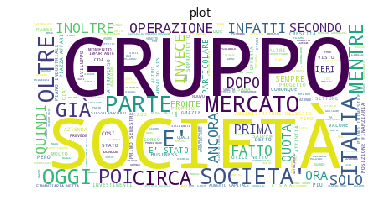

In [16]:
def wordcloud(dataframe):
    wordcloud = WordCloud(background_color="white", stopwords = stopwords.words("italian")).generate(" ".join([i for i in dataframe.str.upper()]))
    plt.imshow(wordcloud)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.figure
    plt.axis("off")
    plt.title("plot")
    plt.show()

wc = wordcloud(colsel_merged['body'])

## Train model:

In [17]:
%time model.train(train_corpus)

CPU times: user 3min 13s, sys: 8.65 s, total: 3min 22s
Wall time: 1min 24s


60747759

In [18]:
model.infer_vector(['oggi', 'voglio', 'comprare', 'una', 'azione', 'di', 'mediaset'])

array([ 0.01004145, -0.15187779, -0.02223546, -0.00148282, -0.04490657,
       -0.10112804,  0.09392265,  0.10975373,  0.03047684,  0.11340716,
       -0.11952207, -0.06049586, -0.00311726,  0.11347844, -0.08986168,
       -0.1917284 ,  0.08034015,  0.26883858,  0.03142837, -0.02369442,
        0.0640521 ,  0.11921773, -0.192228  , -0.0096272 ,  0.01907221,
       -0.08004381, -0.17762899,  0.29067996,  0.09071206, -0.14516667,
        0.14344883,  0.14350422,  0.10500593, -0.0582342 ,  0.01291179,
       -0.12044633, -0.11706378,  0.1247643 , -0.29041216,  0.06115874,
       -0.01750867, -0.14435872, -0.06869747,  0.04706816,  0.11843711,
       -0.21432014,  0.04397471,  0.1324078 ,  0.02473124,  0.39581126], dtype=float32)

In [19]:
ranks = [] #per ogni documento l'indice che indica a che livello si trova nella lista dei simili a se stesso)

second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    
    second_ranks.append(sims[1])

## Evaluate model (raw):

In [24]:
def score(listOfRanks):
    correct = 0
    for e in listOfRanks:
        if(e >= 0 | e <= ):
        #if( e == 0):
            correct = correct + 1
    return correct/len(listOfRanks)

In [25]:
score(ranks)

0.7102229882581063

### NOTE:

#### ranks:
    - num_elements = #num_docs
    - per ogni documento ( in ordine) abbiamo l'indice che rappresenta dove trovare se stesso nella lista dei suoi simili
    - particolarità: il documento 9282 è il 184 documento più simile a se stesso
        
#### second_ranks:
    - num_elements = #num_docs
    - per ogni domcumento ( in ordine) abbiamo il secondo documento più simile

In [22]:
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Document (9282): «toscana aeroporti apprende indiscrezioni stampa commissione valutazione impatto ambientale ministero ambiente espresso parere favorevole masterplan aeroporto amerigo vespucci firenze prevede altre cose realizzazione cosiddetta pista parallela nuovo terminal aeroportuale societa quotata mercato telematico azionario organizzato gestito borsa italiana riserva qualsiasi commento merito fino pubblicazione parere relative documentazioni parte ministeri interessati riferisce nota»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d50,n5,w5,mc2,s0.001,t3):

MOST (9282, 0.8461000919342041): «toscana aeroporti apprende indiscrezioni stampa commissione valutazione impatto ambientale ministero ambiente espresso parere favorevole masterplan aeroporto amerigo vespucci firenze prevede altre cose realizzazione cosiddetta pista parallela nuovo terminal aeroportuale societa quotata mercato telematico azionario organizzato gestito borsa italiana riserva qualsiasi commento merito fino pubb

In [23]:
# Pick a random document from the test corpus and infer a vector from the model

doc_id = random.randint(0, len(train_corpus))

# Compare and print the most/median/least similar documents from the train corpus
print('Train Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
sim_id = second_ranks[doc_id]
print('Similar Document {}: «{}»\n'.format(sim_id, ' '.join(train_corpus[sim_id[0]].words)))

Train Document (7649): «guidare crescita ricavi prysmian parita perimetro netto variazioni prezzo metalli cambi stato posizionamento gruppo business high tech maggior valore aggiunto cavi sistemi sottomarini cavi fibra ottica domanda conferma sostenuta positive performance business prodotti servizi estrazione petrolifera offshore stabili vendite cavi alta tensione terrestri livelli primo trimestre mentre registrano lievi segnali ripresa segmento trade installers cavi distribuzione energia cavi industriali positive performance progetti oil gas segmento elevators parziale contraltare debole andamento automotive alcuni segmenti cavi speciali societa sottolinea miglioramento marginalita registrato primi tre mesi anno rapporto fra ebitda rettificato ricavi salito primo trimestre contributo positivo arrivato impatto valute generato effetti positivi ebitda redditivita gruppo spiega societa continua beneficiare scelta strategica posizionamento business maggior valore aggiunto costante focalizz